In [11]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse
import scipy.stats as stats
def scatter_inputs_outputs(area_func_i, area_func_o, ylim_man=None):
    f, axs = plt.subplots(4,2, figsize=(16,23))
    areas_i, _ = matrix_plot(area_func_i, value_norm='total', postprocess_for_scatter=True, fluorescence=False, ax=axs[0,0])
    #areas_o, _ = matrix_plot(area_func_o, value_norm='custom_pedestal', postprocess_for_scatter=True, fluorescence=True, ax=axs[0,1])
    
    areas_o1, _ = matrix_plot(mono_outputs_antero(), value_norm='custom_pedestal', postprocess_for_scatter=True, fluorescence=True, ax=axs[0,1])
    areas_o2, _ = matrix_plot(di_outputs_antero_roi(1250, 'custom_pedestal', True), value_norm='custom_pedestal', postprocess_for_scatter=True, fluorescence=True, ax=axs[0,1])
    areas_o3, _ = matrix_plot(inputs_antero_MF_roi(), value_norm='custom_pedestal', postprocess_for_scatter=True, fluorescence=True, ax=axs[0,1])
    
    areas = list(set(areas_i + areas_o1 + areas_o2 + areas_o3))
    area_func_union = custom_rois(areas)
    _, _ = matrix_plot(area_func_union, value_norm='total', postprocess_for_scatter=True, fluorescence=False, ax=axs[1,0])
    _, _ = matrix_plot(area_func_union, value_norm='custom_pedestal', postprocess_for_scatter=True, fluorescence=True, ax=axs[1,1])
    
    area_labels_i, cells_i, _, _, datasets, areas_title, axis_title_i = get_matrix_data(area_func_union, postprocess_for_scatter=True, fluorescence=False, value_norm='total')
    area_labels_o, cells_o, _, _, _, _, axis_title_o = get_matrix_data(area_func_union, postprocess_for_scatter=True, fluorescence=True, value_norm='custom_pedestal')
    
    ylim = np.max(cells_o) * 10
    ylim_lin = np.max(cells_o) * 1.1 if ylim_man is None else ylim_man
    xlim = np.max(cells_i) * 1.1
    
    left_x, left_y = cells_i[0], cells_o[0]
    right_x, right_y = cells_i[1], cells_o[1]
    left_y_log, right_y_log = np.log(cells_o[0]), np.log(cells_o[1]) # fit to log transformed data and then plot the exponential later
    left_coef = np.polyfit(left_x, left_y_log, 1)
    right_coef = np.polyfit(right_x, right_y_log, 1)
    left_poly1d_fn = np.poly1d(left_coef) # poly1d_fn is now a function which takes in x and returns an estimate for y
    right_poly1d_fn = np.poly1d(right_coef)
    line_vals = np.linspace(0, xlim, 100)
    
    def fit_model(model, y, x, name, c, log=False, labely=0.95, ax=None):
        X = np.array(x).reshape(len(x),1)
        line_X = np.arange(min(x), max(x))[:, np.newaxis]
        model.fit(X, y)
        line_y = model.predict(line_X)
        if log:
            line_y = np.exp(line_y)
        loss = mse(y, model.predict(X)) # compare true y values with the predictions based on x values
        if not log:
            loss = np.log(loss)
        r, p = stats.pearsonr(x, y)
        if ax != None:
            ax.plot(line_X, line_y, color=c, linewidth=2, label=f'{name} loss={loss:.2f}')
            ax.annotate(f'r = {r:.2f}, p = {p:.3f}', xy=(0.05, labely), xycoords='axes fraction')
        return model.estimator_.coef_, model.estimator_.intercept_, loss
    
    axs[2,0].plot(left_x, left_y, 'ko', ms=1)
    axs[2,0].set_title(f'LS ({areas_title})')
    axs[2,0].set_xlabel(f'Input / {axis_title_i}')
    axs[2,0].set_ylabel(f'Output / {axis_title_o}')
    axs[2,0].set_yscale('log')
    axs[2,1].plot(right_x, right_y, 'ko', ms=1)
    axs[2,1].set_title(f'LV ({areas_title})')
    axs[2,1].set_xlabel(f'Input / {axis_title_i}')
    axs[2,1].set_ylabel(f'Output / {axis_title_o}')
    axs[2,1].set_yscale('log')
    
    # same without setting scale to log
    axs[3,0].plot(left_x, left_y, 'ko', ms=1)
    axs[3,0].set_title(f'LS ({areas_title})')
    axs[3,0].set_xlabel(f'Input / {axis_title_i}')
    axs[3,0].set_ylabel(f'Output / {axis_title_o}')
    axs[3,1].plot(right_x, right_y, 'ko', ms=1)
    axs[3,1].set_title(f'LV ({areas_title})')
    axs[3,1].set_xlabel(f'Input / {axis_title_i}')
    axs[3,1].set_ylabel(f'Output / {axis_title_o}')
    
    axs[2,0].set_ylim(10,ylim)
    axs[2,1].set_ylim(10,ylim)
    axs[2,0].set_xlim(-0.2,xlim)
    axs[2,1].set_xlim(-0.2,xlim)
    axs[3,0].set_ylim(-0.1,ylim_lin)
    axs[3,1].set_ylim(-0.1,ylim_lin)
    axs[3,0].set_xlim(-0.2,xlim)
    axs[3,1].set_xlim(-0.2,xlim)
    
    #axs[2,0].plot(line_vals, np.exp(left_poly1d_fn(line_vals)), '-r', label='Least squares (log tr.)')
    #axs[2,1].plot(line_vals, np.exp(right_poly1d_fn(line_vals)), '-r', label='Least squares (log tr.)')
    l_ransac_log = linear_model.RANSACRegressor(max_trials=30)
    r_ransac_log = linear_model.RANSACRegressor(max_trials=30)
    l_ransac_loglin = linear_model.RANSACRegressor(max_trials=30)
    r_ransac_loglin = linear_model.RANSACRegressor(max_trials=30)
    l_ransac = linear_model.RANSACRegressor(max_trials=30)
    r_ransac = linear_model.RANSACRegressor(max_trials=30)
    m, c, loss = fit_model(l_ransac_log, left_y_log, left_x, 'RANSAC (log tr.)', c='m', log=True, ax=axs[2,0], labely=0.9)
    m, c, loss = fit_model(r_ransac_log, right_y_log, right_x, 'RANSAC (log tr.)', c='m', log=True, ax=axs[2,1], labely=0.9)
    m, c, loss = fit_model(l_ransac_loglin, left_y, left_x, 'RANSAC (lin)', c='b', log=False, ax=axs[2,0])
    m, c, loss = fit_model(r_ransac_loglin, right_y, right_x, 'RANSAC (lin)', c='b', log=False, ax=axs[2,1])
    m, c, loss = fit_model(l_ransac, left_y, left_x, 'RANSAC (log tr.)', c='b', log=False, ax=axs[3,0])
    m, c, loss = fit_model(r_ransac, right_y, right_x, 'RANSAC (log tr.)', c='b', log=False, ax=axs[3,1])
    axs[2,0].legend()
    axs[2,1].legend()

In [12]:
# Di input U Mono input
area_func_i = di_inputs_retro(threshold=0.5, select_norm='total', fluorescence=False) # threshold is low because inputs don't have many outputs in disynaptic output regions

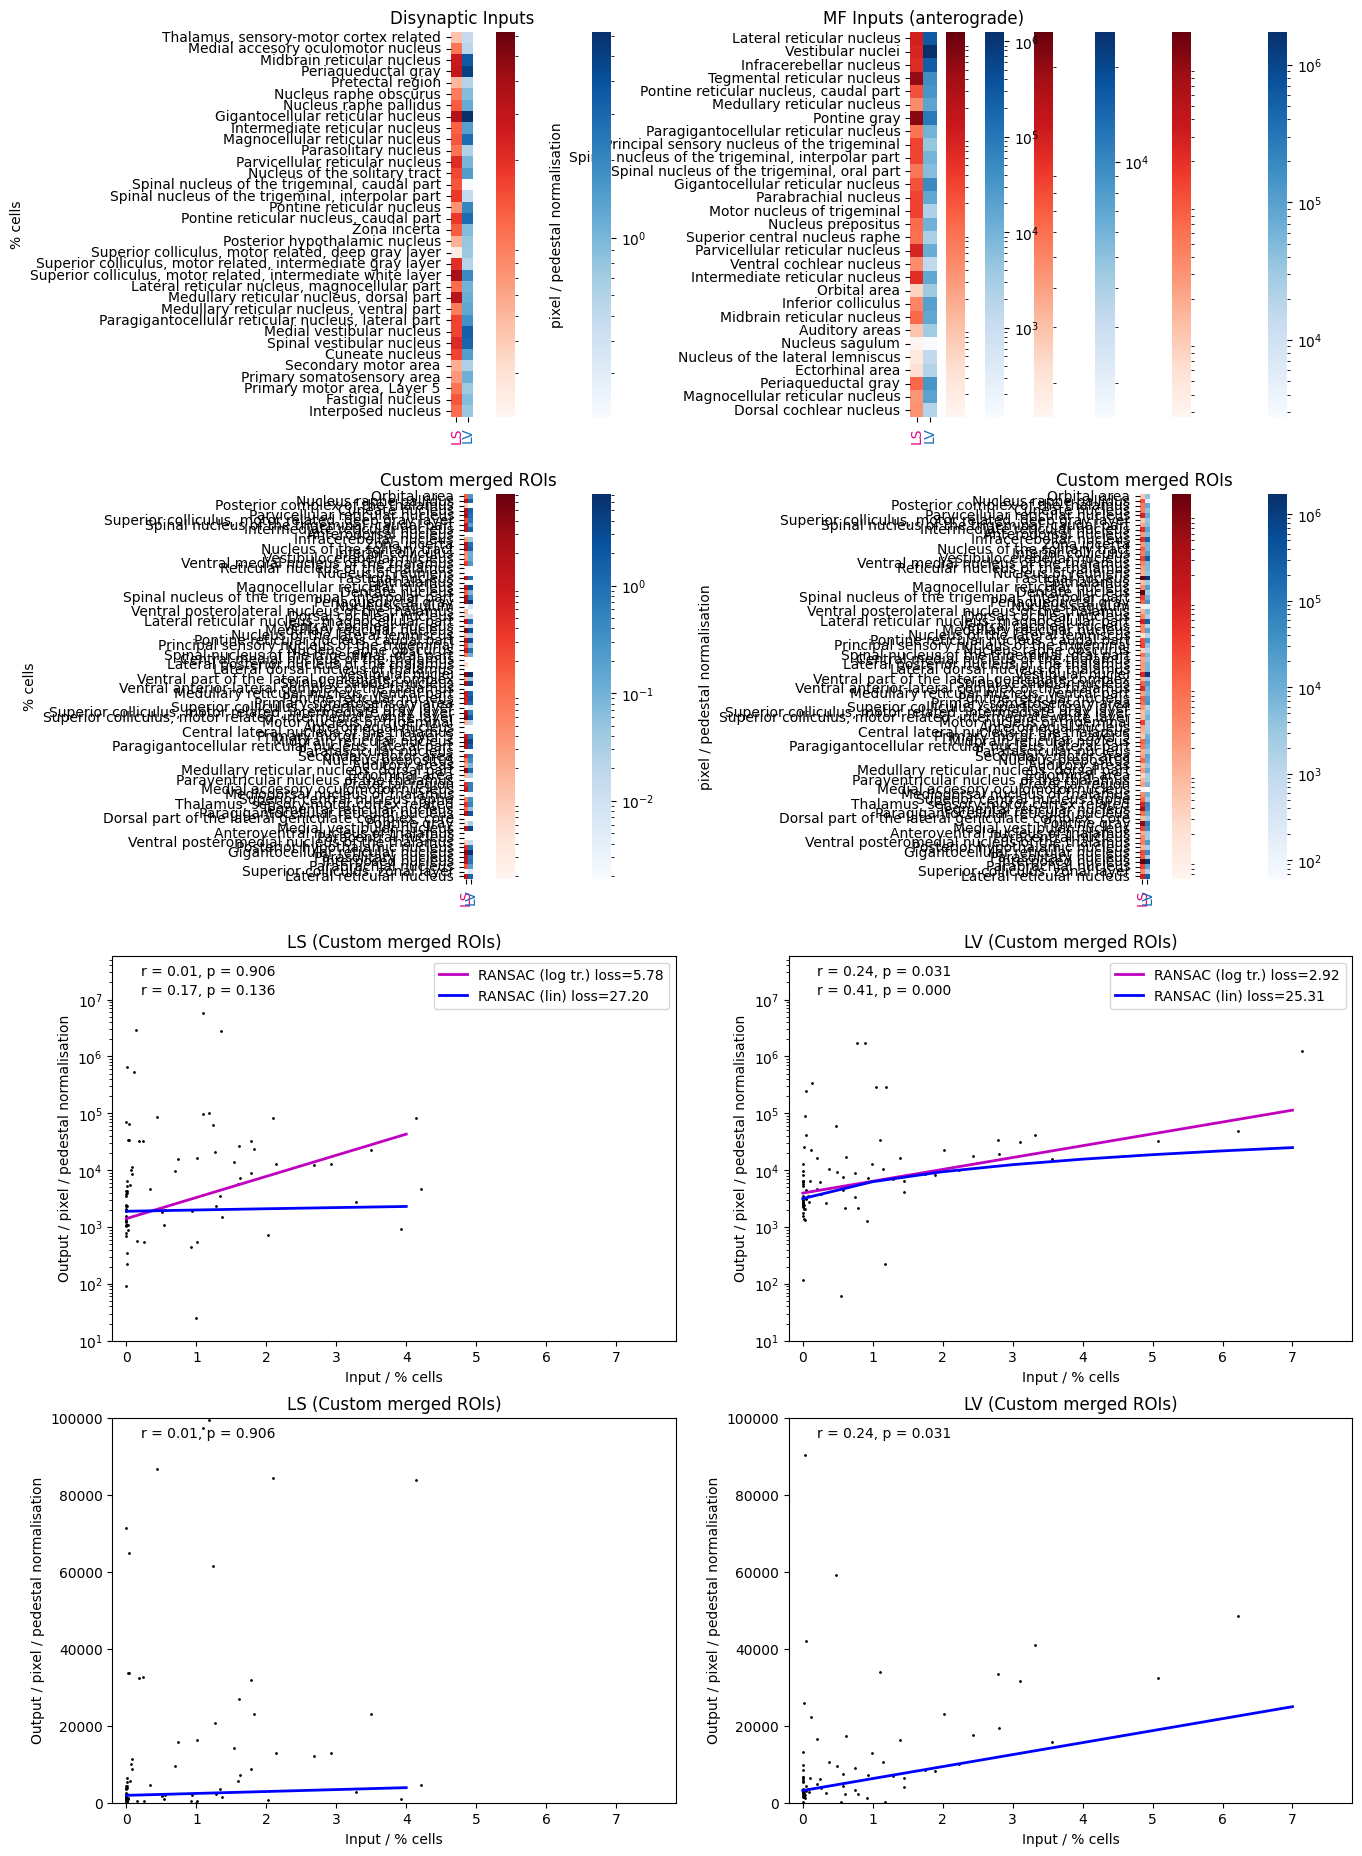

In [19]:
area_func_o = inputs_antero_MF_roi()
scatter_inputs_outputs(area_func_i, area_func_o, ylim_man=100_000)
btf.save('inout_scatter_all', as_type='pdf')

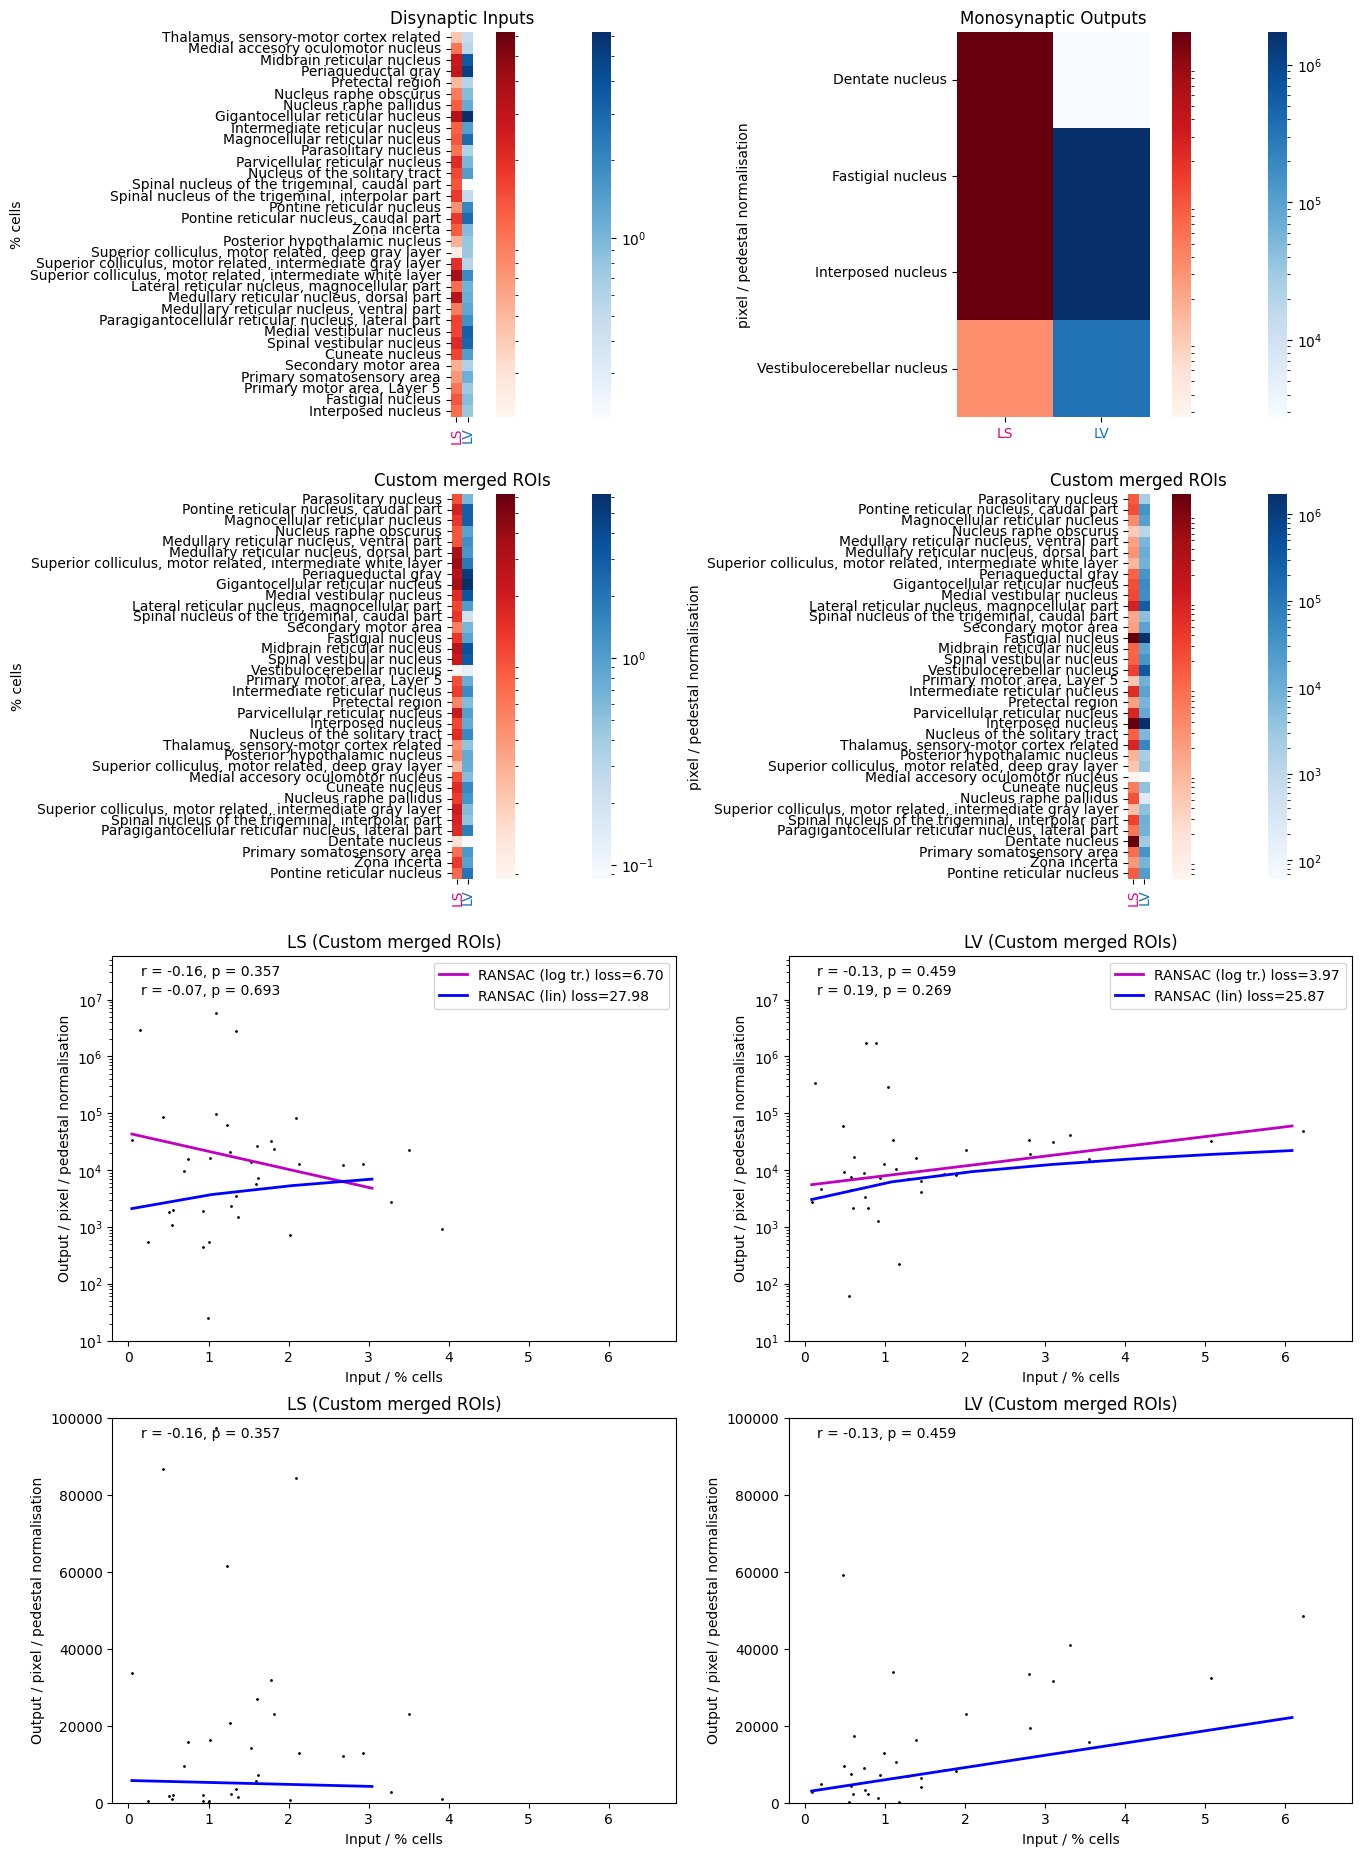

In [138]:
# Di input U Mono output
area_func_o = mono_outputs_antero()
scatter_inputs_outputs(area_func_i, area_func_o, ylim_man=100_000)

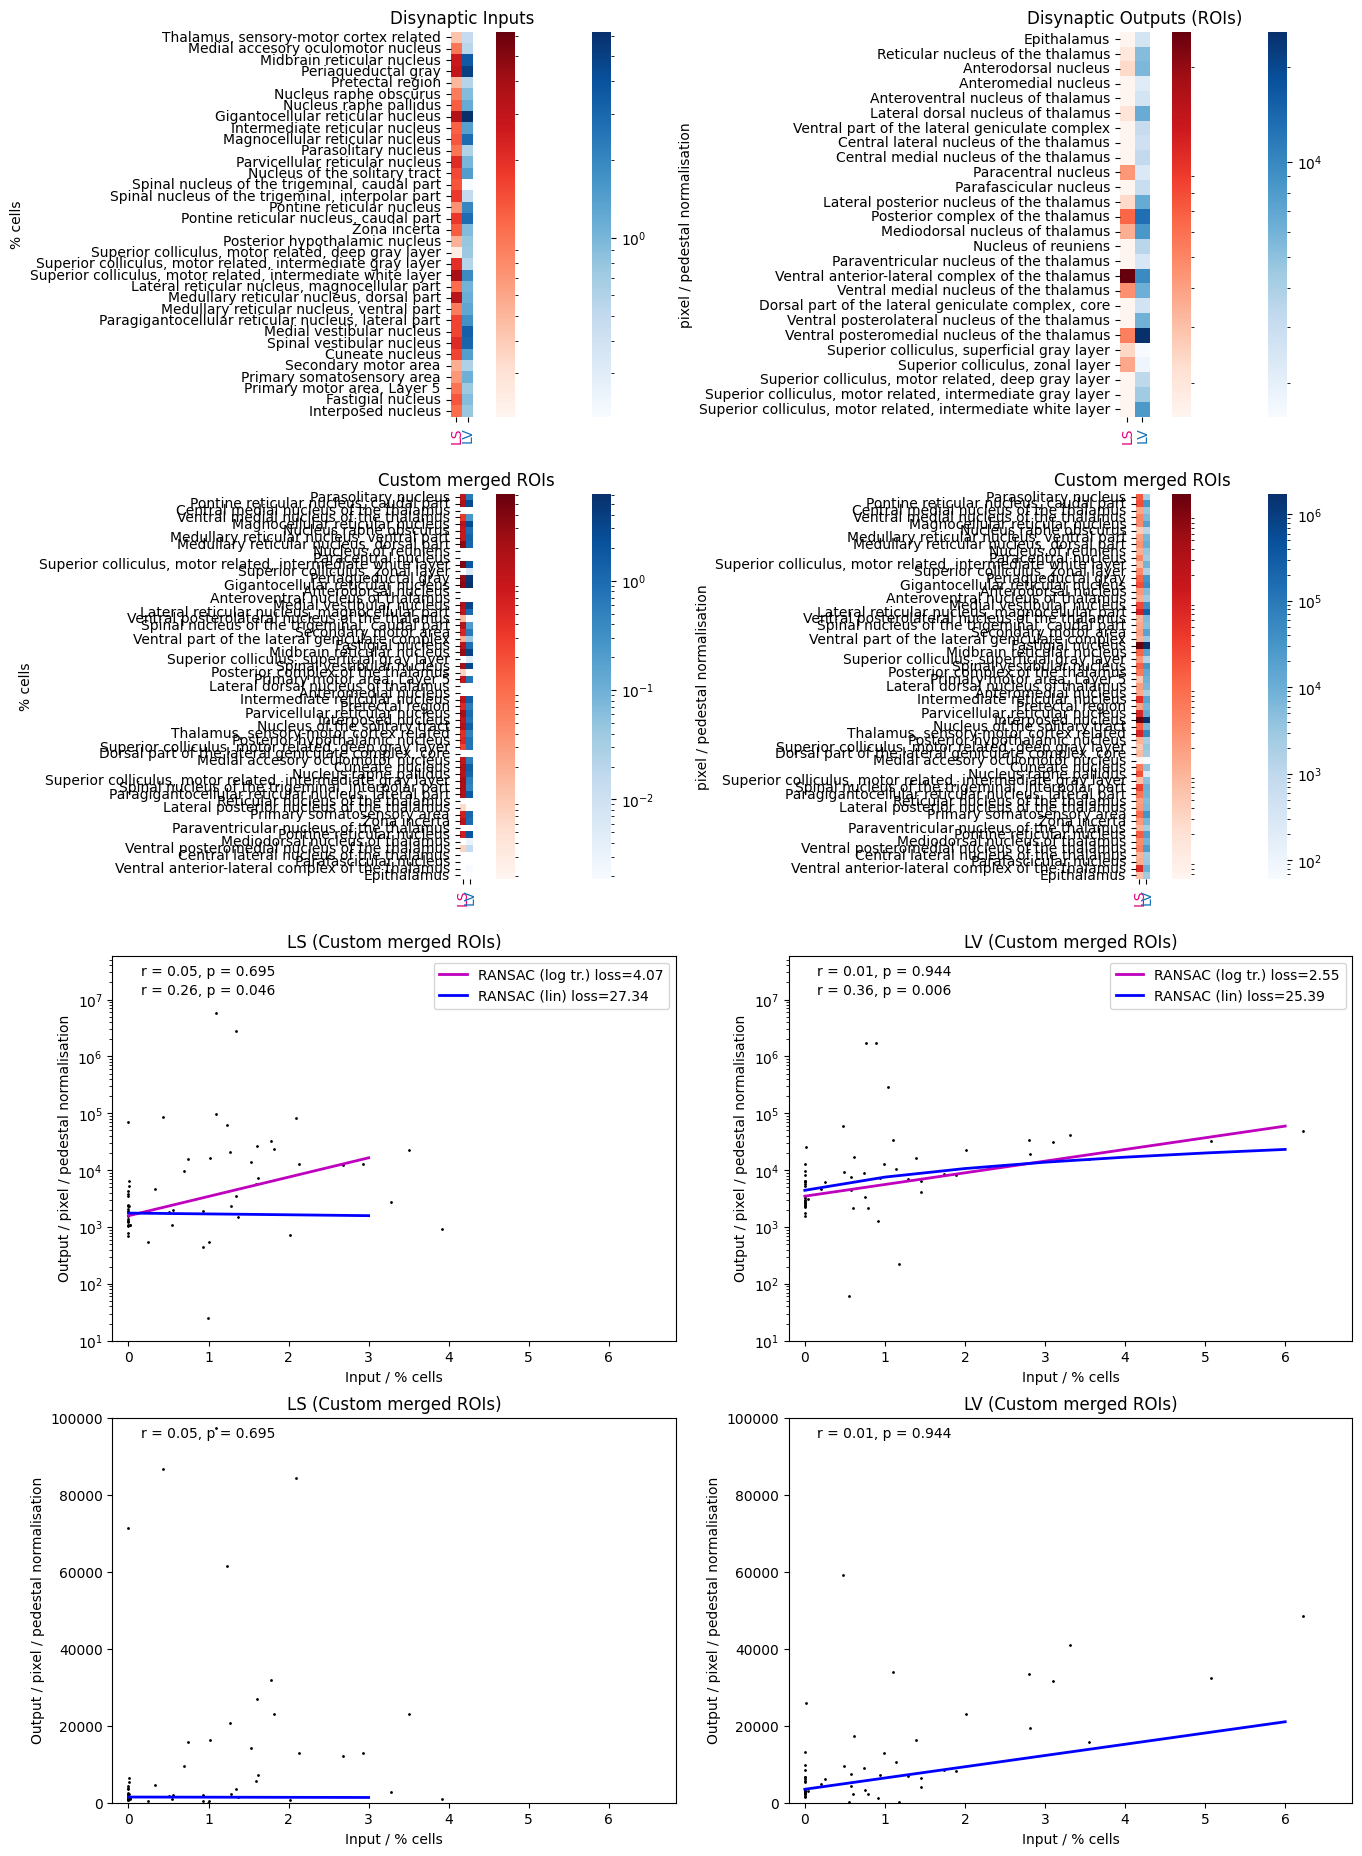

In [130]:
# Di input U Di output
area_func_o = di_outputs_antero_roi(1250, 'custom_pedestal', True)
scatter_inputs_outputs(area_func_i, area_func_o, ylim_man=100_000)

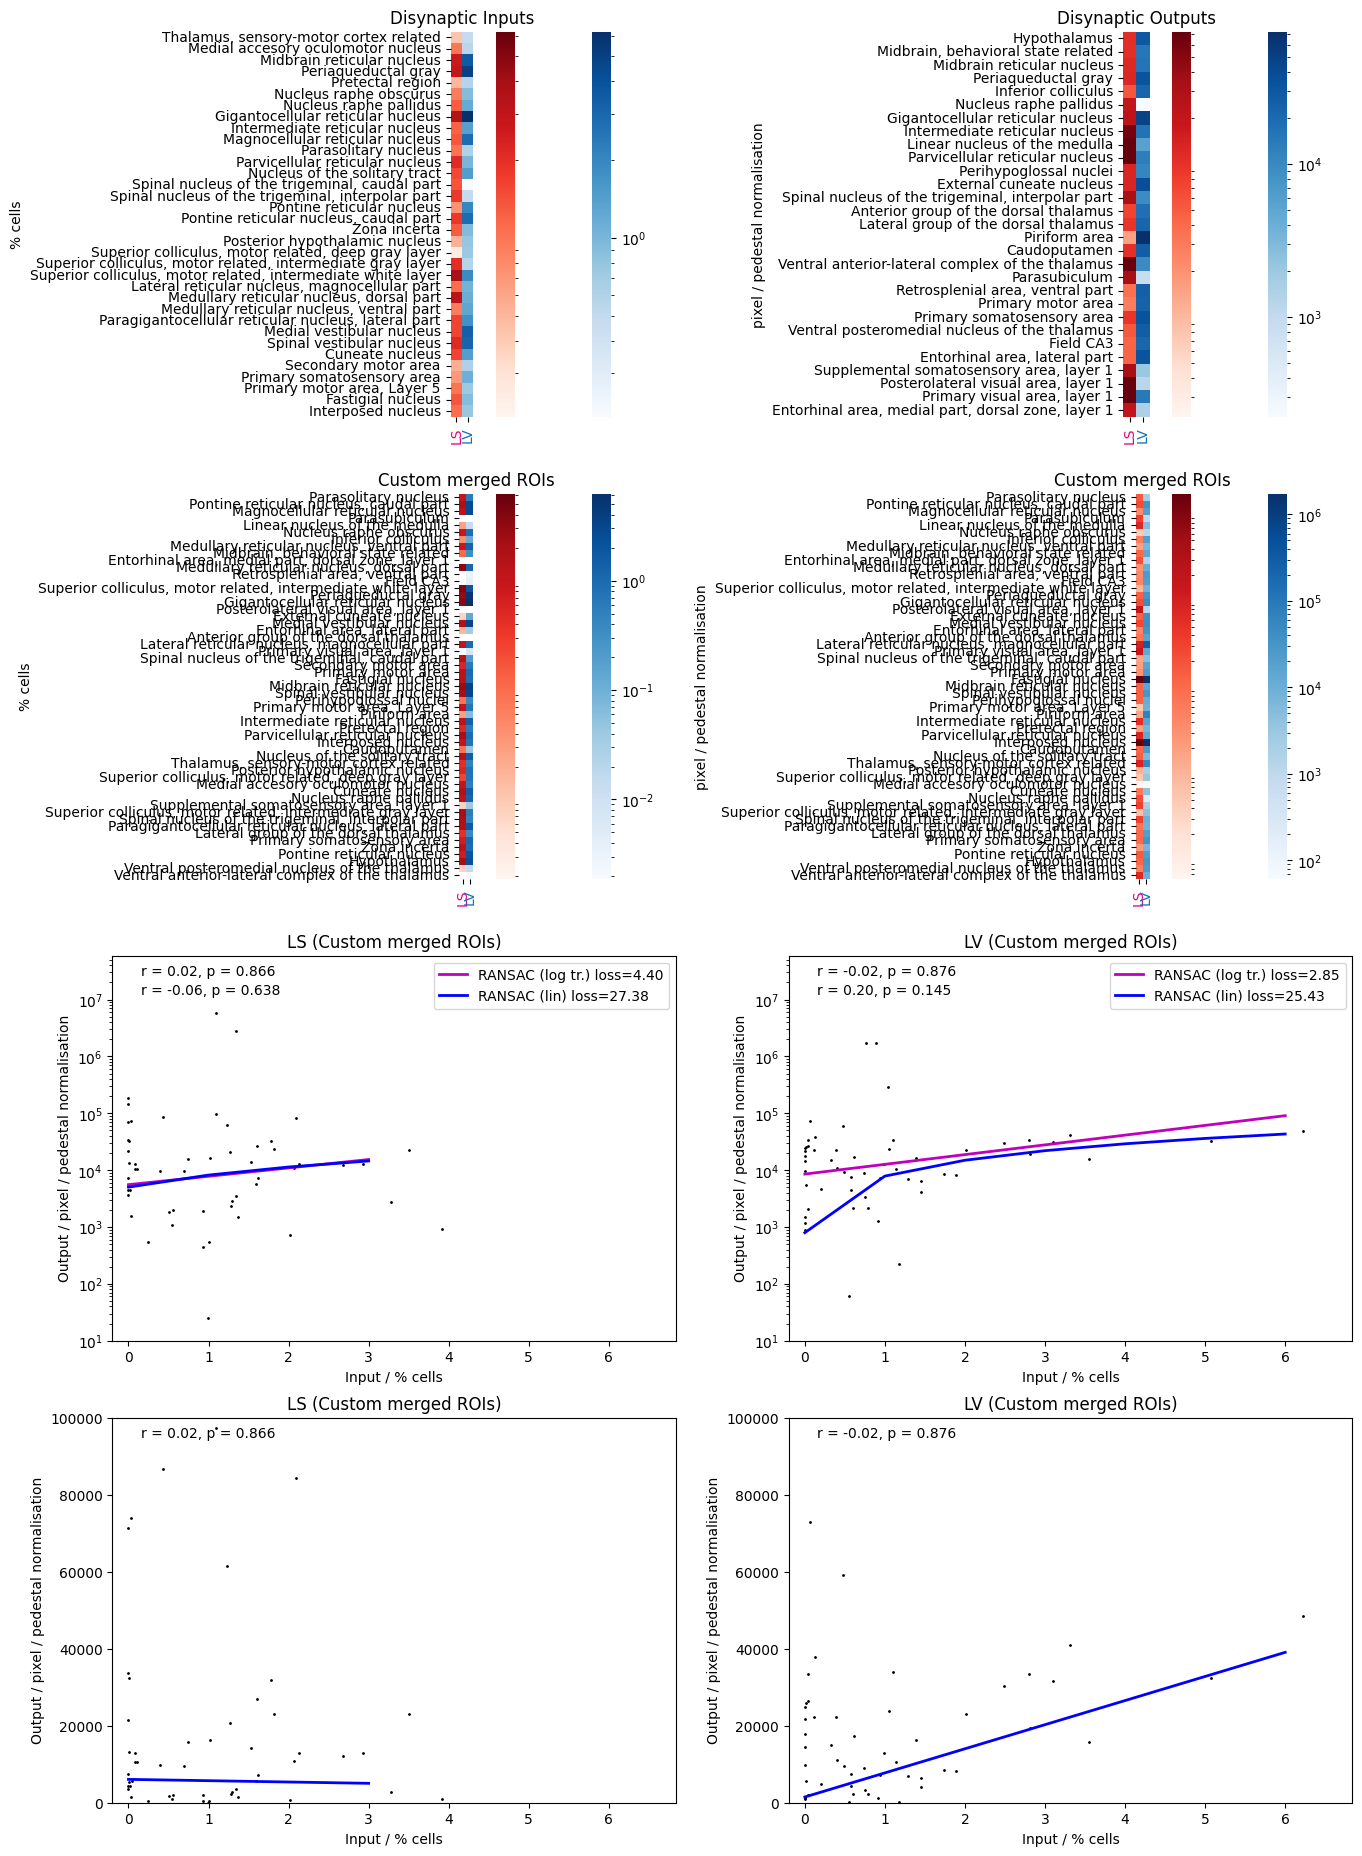

In [139]:
# Di input U Di output ALT
area_func_o = di_outputs_antero(10000, 'custom_pedestal', True)
scatter_inputs_outputs(area_func_i, area_func_o, ylim_man=100_000)

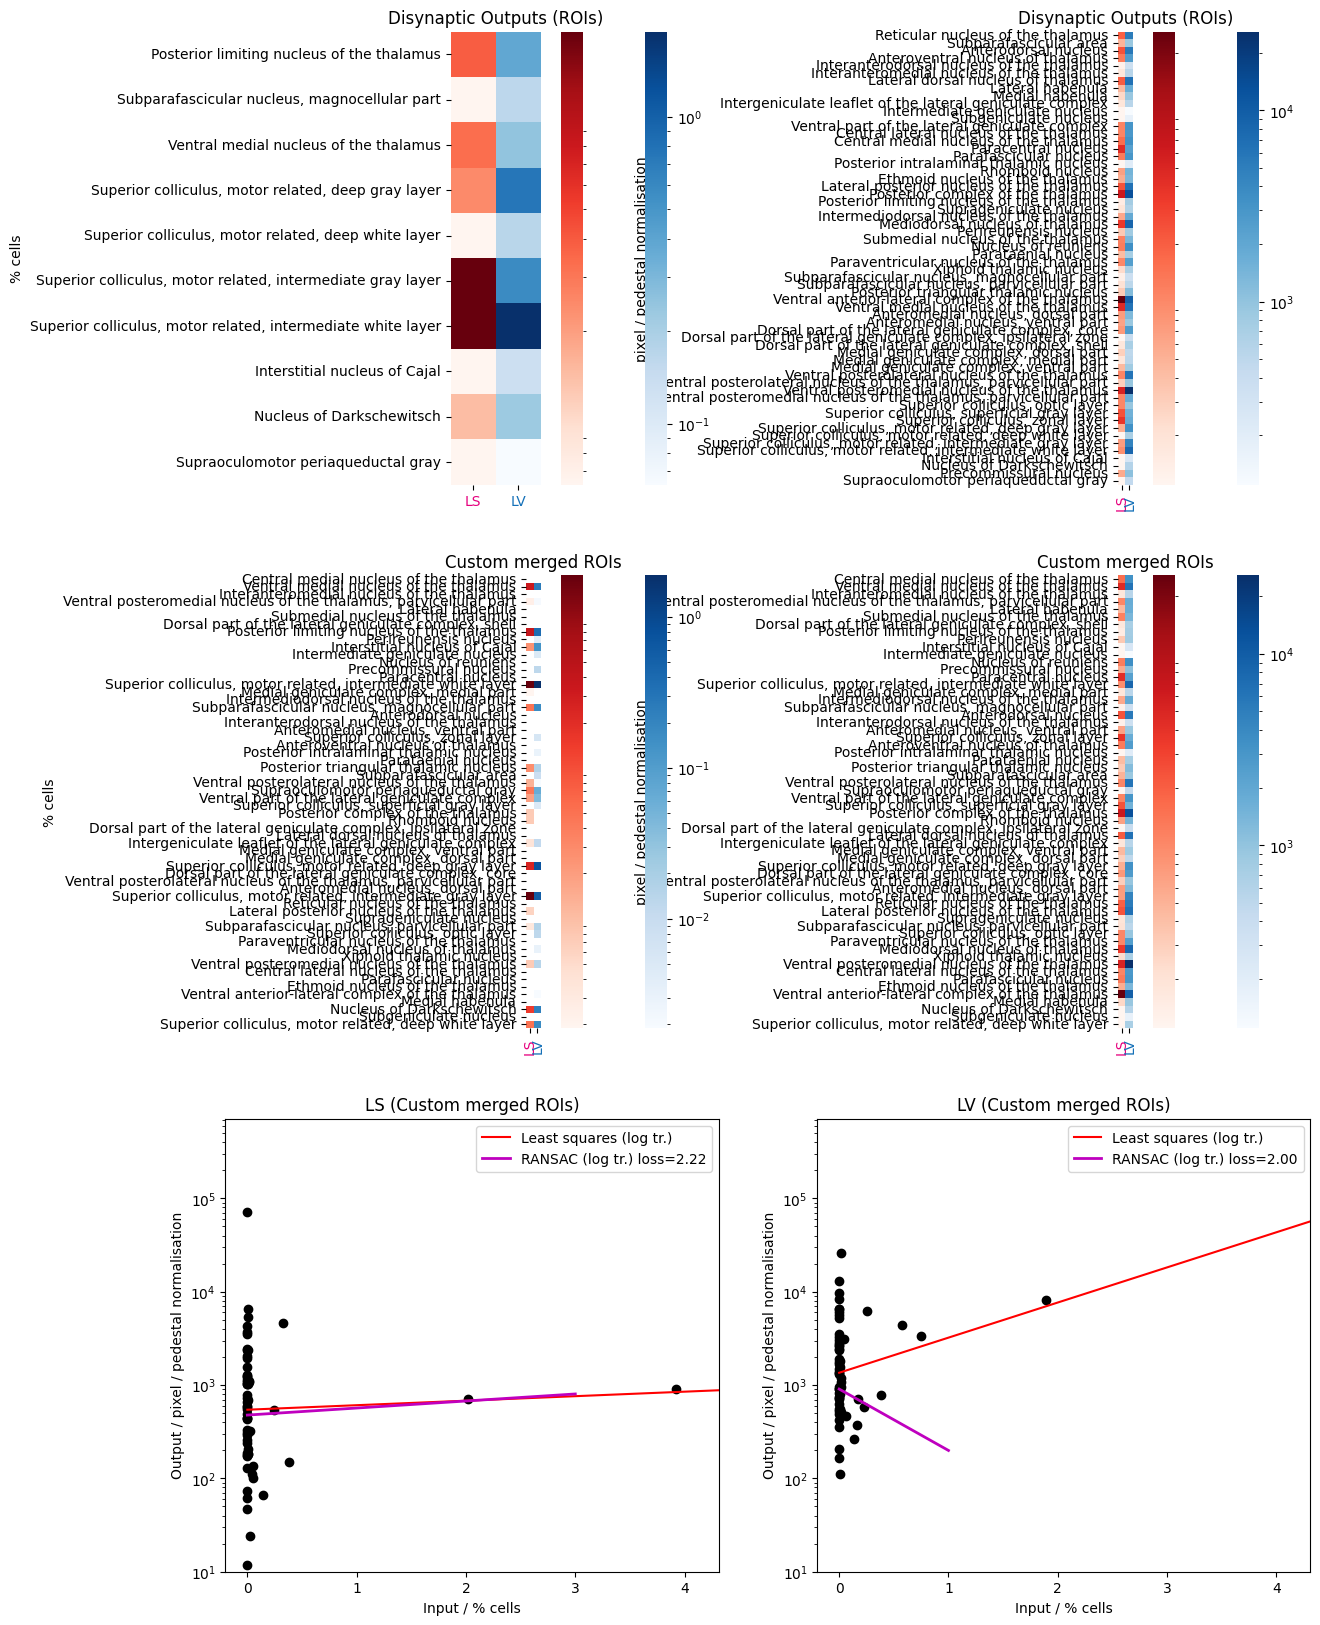

In [38]:
# selection of disynaptic output regions
area_func_i = di_outputs_antero_roi(threshold=0.05, select_norm='total', fluorescence=False) # threshold is low because inputs don't have many outputs in disynaptic output regions
area_func_o = di_outputs_antero_roi(threshold=75, select_norm='custom', fluorescence=True)
scatter_inputs_outputs(area_func_i, area_func_o)

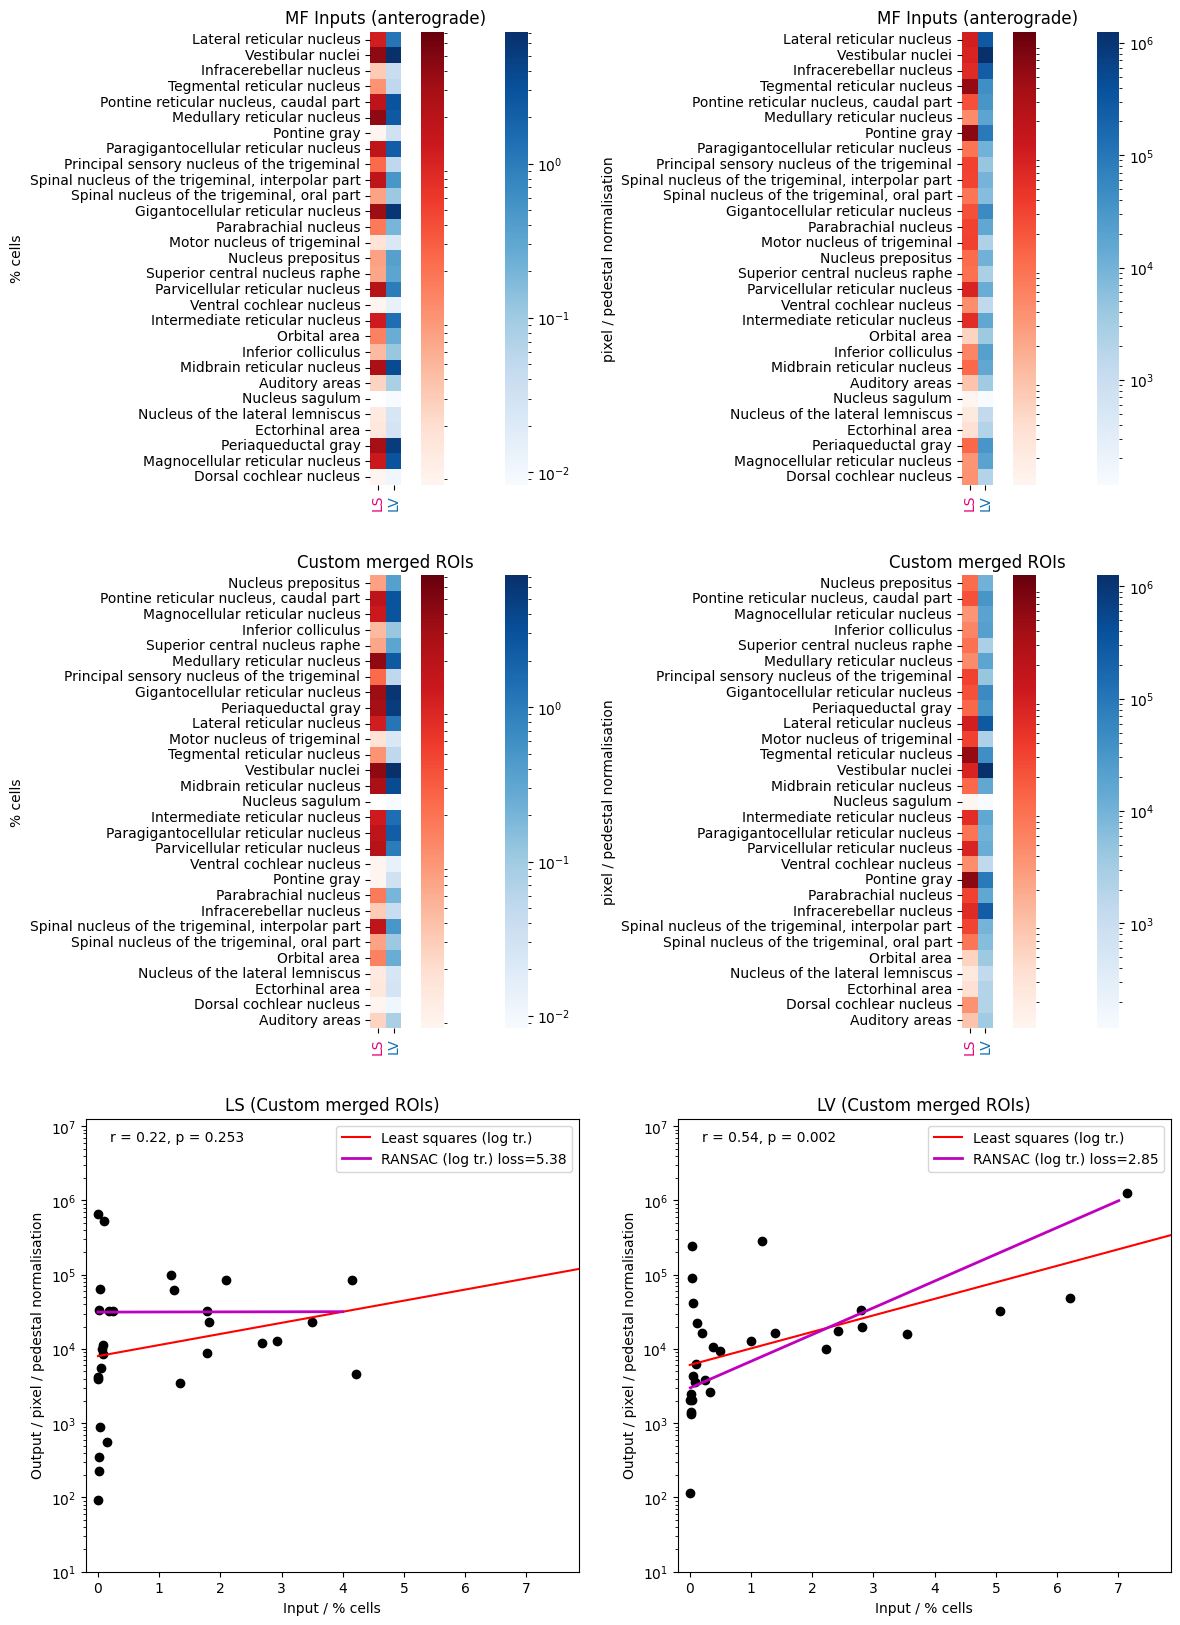

In [50]:
area_func_io = inputs_antero_MF_roi() # prescribed MF monosynaptic inputs
scatter_inputs_outputs(area_func_io, area_func_io)

[[ 380226.27350848]
 [1071412.47137406]
 [ 198162.1240357 ]
 [1736834.34370524]
 [ 112026.36056845]
 [  83534.87541732]
 [  10869.57515538]
 [  33550.50662586]]


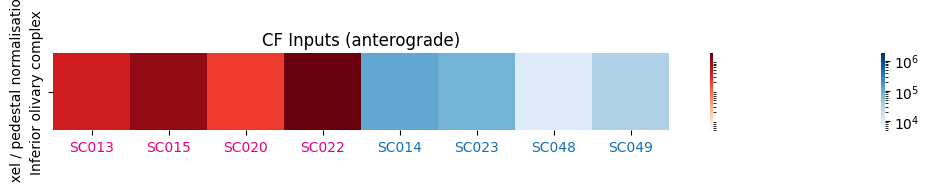

In [90]:
areas, _ = matrix_plot(inputs_antero_CF(), IO=False, value_norm='custom_pedestal', vbounds=(5000,1800000), figsize=(13,1), postprocess_for_scatter=False, fluorescence=True)
btf.save('ANOVAmat_CF_input_antero', as_type='pdf')